# 04 — Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load Data

In [2]:
df = pd.read_csv('../data/processed/otodom_features.csv')
print(f'Shape: {df.shape}')
df.head()

Shape: (502, 16)


,price,surface,no_of_rooms,price_per_m2,"market_[""market"",""secondary""]",market_unknown,advertiser_type_developer,advertiser_type_private,advertiser_type_unknown,form_of_property_spółdzielcze wł. prawo do lokalu,form_of_property_udział,form_of_property_unknown,is_for_sale_True,voivodeship_encoded,city_encoded,rooms_per_surface
0,549000.0,41.8,2.0,13133.971292,True,False,False,False,False,False,False,True,True,6,7,0.047847
1,410000.0,64.0,3.0,6406.250000,True,False,False,True,False,True,False,False,True,6,29,0.046875
2,129000.0,92.0,4.0,1402.173913,True,False,False,False,False,False,False,False,True,6,19,0.043478
3,820000.0,106.0,4.0,7735.849057,True,False,False,True,False,False,False,True,True,6,17,0.037736
4,1399000.0,189.4,5.0,7386.483633,False,False,False,False,False,False,False,True,True,6,17,0.026399


## Prepare X and y

In [3]:
X = df.drop(columns=['price', 'price_per_m2'])
y = df['price']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (502, 14)
y shape: (502,)


## Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')

Train: (401, 14)
Test: (101, 14)


## Scale Features

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Define Models

In [6]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

## Train and Evaluate

In [7]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    print(f'{name}: MAE={mae:,.0f} | RMSE={rmse:,.0f} | R²={r2:.4f}')

results_df = pd.DataFrame(results)
results_df

Linear Regression: MAE=189,887 | RMSE=253,638 | R²=0.4074
Decision Tree: MAE=275,905 | RMSE=365,244 | R²=-0.2288
Random Forest: MAE=187,172 | RMSE=260,215 | R²=0.3763
Gradient Boosting: MAE=173,760 | RMSE=240,165 | R²=0.4687


,Model,MAE,RMSE,R2
0,Linear Regression,189887.134660,253638.470603,0.407402
1,Decision Tree,275905.039604,365244.326235,-0.228843
2,Random Forest,187172.178020,260214.639554,0.376275
3,Gradient Boosting,173759.632380,240165.034484,0.468689


## Model Comparison

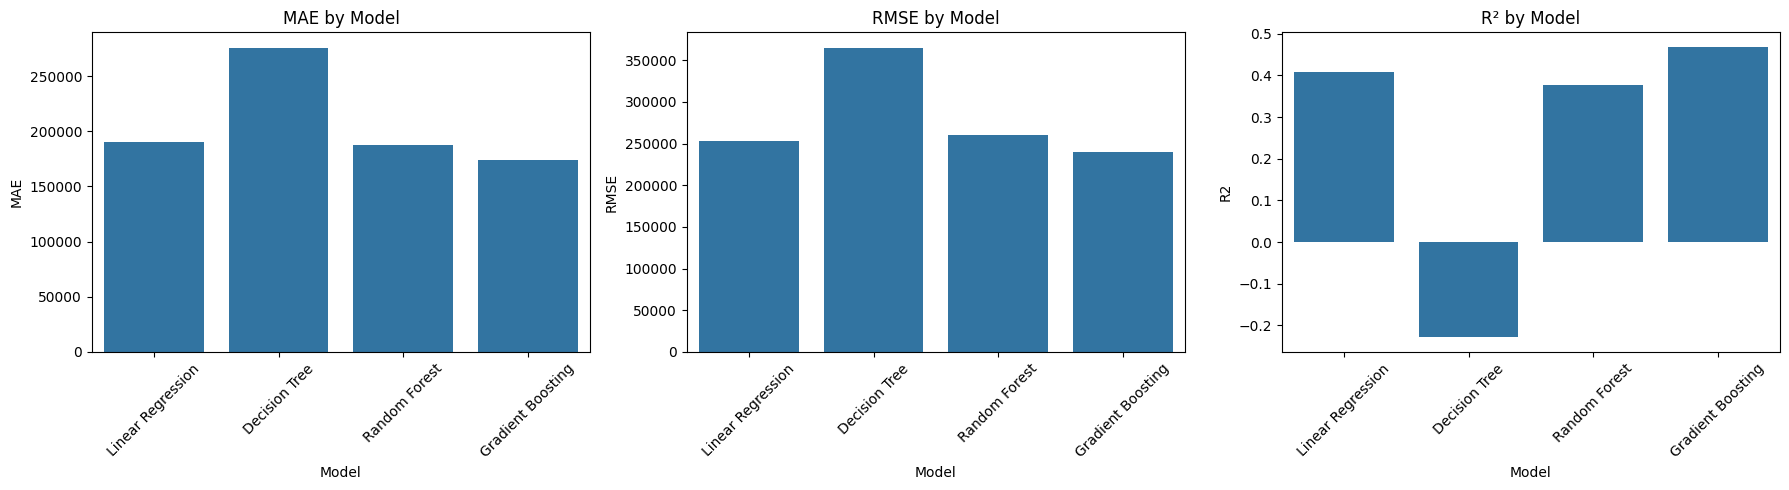

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=results_df, x='Model', y='MAE', ax=axes[0])
axes[0].set_title('MAE by Model')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=results_df, x='Model', y='RMSE', ax=axes[1])
axes[1].set_title('RMSE by Model')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(data=results_df, x='Model', y='R2', ax=axes[2])
axes[2].set_title('R² by Model')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Best Model — Predictions vs Actual

Best model: Gradient Boosting


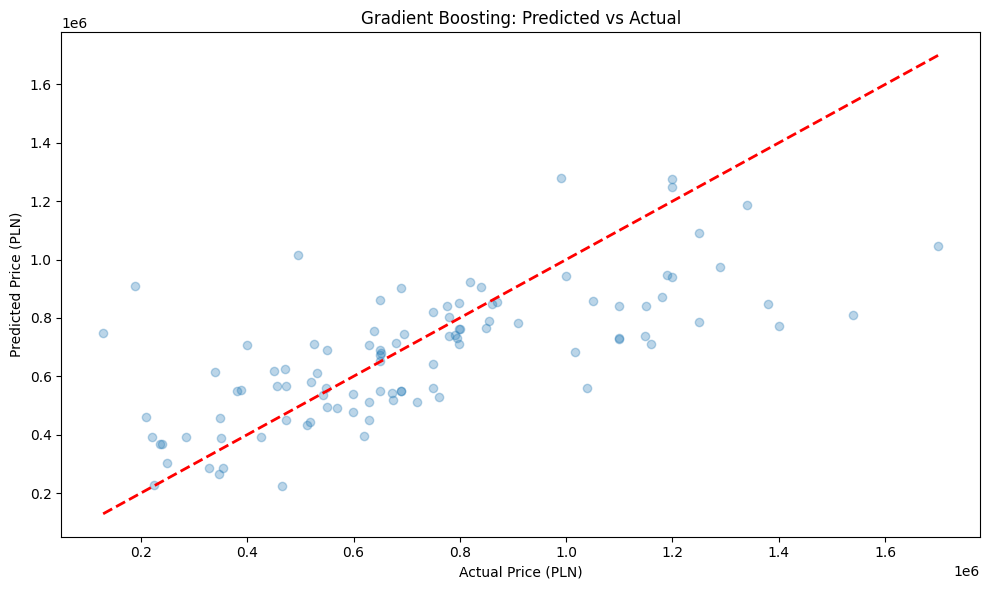

In [9]:
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

print(f'Best model: {best_model_name}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'{best_model_name}: Predicted vs Actual')
plt.xlabel('Actual Price (PLN)')
plt.ylabel('Predicted Price (PLN)')
plt.tight_layout()
plt.savefig('../results/figures/predicted_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

## Residuals

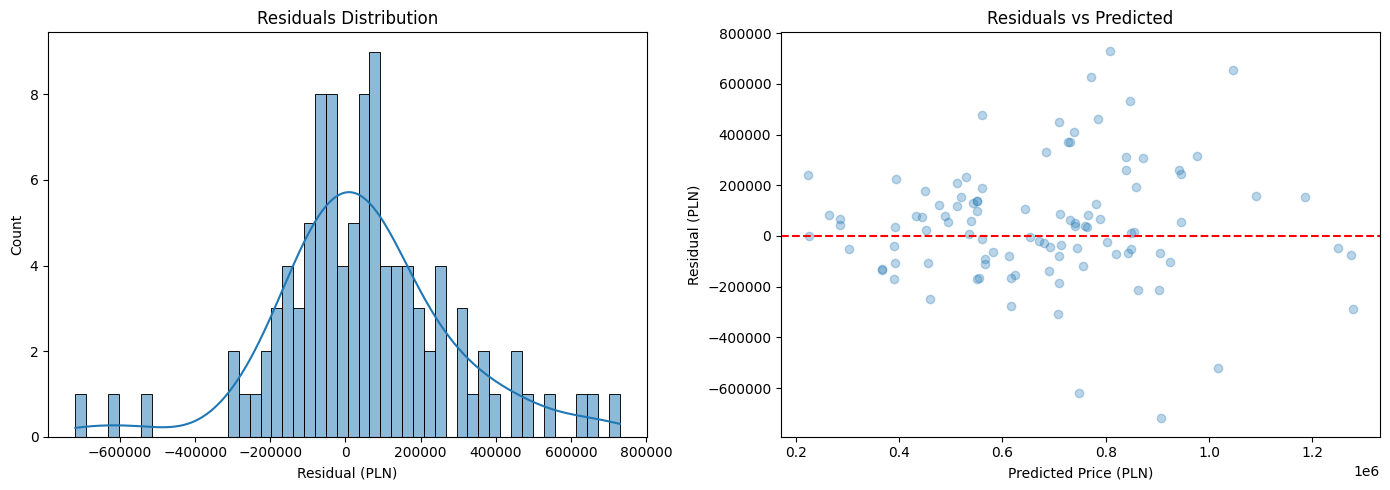

In [10]:
residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(residuals, bins=50, kde=True, ax=axes[0])
axes[0].set_title('Residuals Distribution')
axes[0].set_xlabel('Residual (PLN)')

axes[1].scatter(y_pred_best, residuals, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residuals vs Predicted')
axes[1].set_xlabel('Predicted Price (PLN)')
axes[1].set_ylabel('Residual (PLN)')

plt.tight_layout()
plt.savefig('../results/figures/residuals.png', dpi=150, bbox_inches='tight')
plt.show()

## Feature Importance

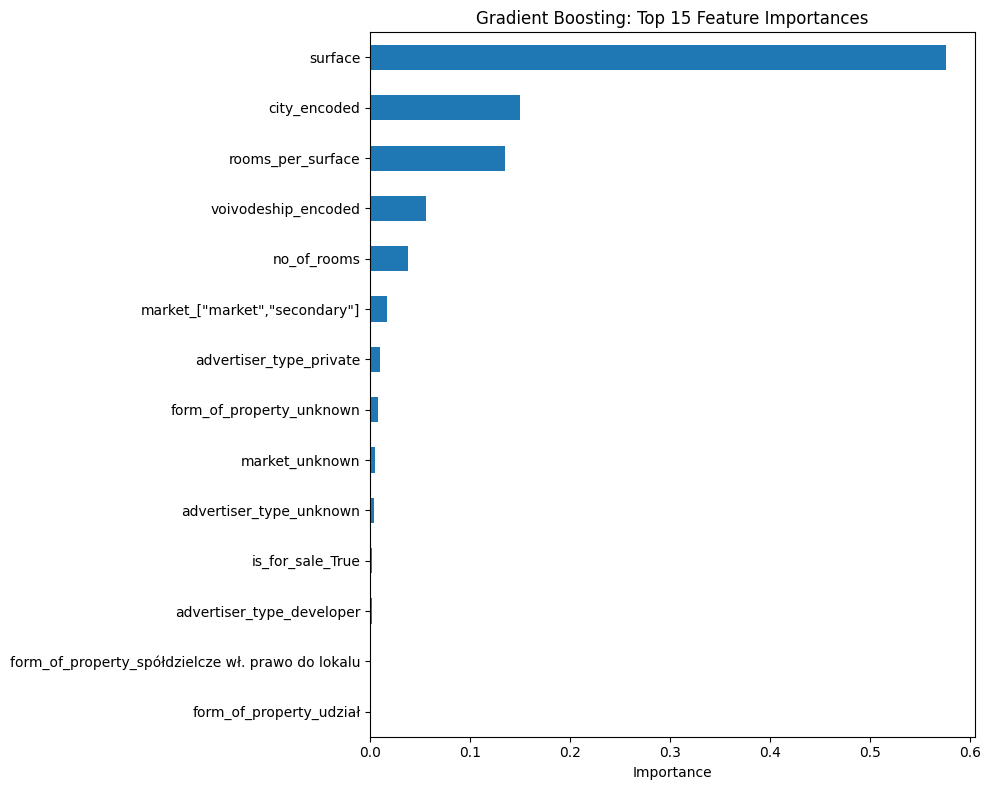

In [11]:
if hasattr(best_model, 'feature_importances_'):
    importance = pd.Series(best_model.feature_importances_, index=X.columns)
    importance = importance.sort_values(ascending=True)
    
    plt.figure(figsize=(10, 8))
    importance.tail(15).plot(kind='barh')
    plt.title(f'{best_model_name}: Top 15 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('../results/figures/feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

## Summary

In [12]:
print('=== MODEL COMPARISON ===')
print(results_df.to_string(index=False))
print(f'\nBest model: {best_model_name}')
print(f'R² = {results_df.loc[results_df["R2"].idxmax(), "R2"]:.4f}')
print(f'MAE = {results_df.loc[results_df["R2"].idxmax(), "MAE"]:,.0f} PLN')

=== MODEL COMPARISON ===
            Model           MAE          RMSE        R2
Linear Regression 189887.134660 253638.470603  0.407402
    Decision Tree 275905.039604 365244.326235 -0.228843
    Random Forest 187172.178020 260214.639554  0.376275
Gradient Boosting 173759.632380 240165.034484  0.468689

Best model: Gradient Boosting
R² = 0.4687
MAE = 173,760 PLN
